# Homework 1: Coding Part
Due: Feb 15, 2021 at 11:59 pm

Submit through Sakai

# Classification of MNIST

MNIST is a dataset of images, consisting of handwritten numbers 0-9 widely used as a benchmark in machine learning. While the dataset is very simple, it is still in seminal papers to demonstrate proof of concept (i.e. [Dynamic Routing](https://arxiv.org/pdf/1710.09829.pdf)). Below we load some sample images of handwritten digits for you.

Benchmark datasets are very useful, to note a couple other widely used benchmarks: [SVHN](http://ufldl.stanford.edu/housenumbers/) (Street View House Numbers), [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (Like MNIST, but more fashion), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) (10 and 100 different objects), and [ImageNet](http://www.image-net.org/) (very large real world image dataset).

We load up the MNIST dataset below. Eeach image in the MNIST set is 28x28 pixels and is frequently "vectorized" into a vector that contains 784 entries.

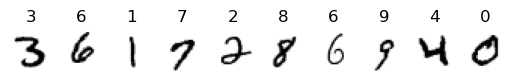

In [1]:
# Import datasets (just run this block)
%matplotlib inline

from sklearn import datasets
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# might take a few minutes
digit, target = fetch_openml(
    "mnist_784", return_X_y=True, as_frame=False)
digit = (digit/255.0).reshape(-1,28,28)
target = target.astype(int)
for index, (image, label) in enumerate(list(zip(digit, target))[12:22]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

# Part I

In this homework, you will develop software to classify images of two unique hand-written digits of your choice. That is, you will set aside 300 examples of one hand-written digit, and 300 examples of another hand-written digit, and will develop a computational process to automatically categorize each digit type (i.e., for future example hand-written digits that you may encounter).

We start by choosing the digits and selecting 300 samples for each of them. We will then create our training and testing datasets by splitting these sample groups, using `sklearn.model_selection.train_test_split`, a convenient function. We want to save 10% of the data for testing our developed algorithm. Remember that we want to save our test sets separately, so we can fairly evaluate how well our new algorithms classify on new, *unseen* image data.

`X_test` and `y_test` should be used to evaluate the performance of the classifier you build at the end, where the former is the image dataset itself, while the latter are the associated labels for each image. Moving forward here, please just work with `X_train` and `y_train`, which are the associated dataset and labels that you can use for algorithm development.

So for this block:
a. `digit` array holds all the images. 
b. `targets` array holds the correspnding labels.

Your task is to:
1. Choose the numbers you wish to classify.
2. Using a condition on the `target` array, find which indices hold the digits of your choice. Take the top 300 indices from this selection for both digits.
3. Create the new dataset by concatenating image arrays both digits and label arrays for both digits.

In [2]:
#@title Hints
# 1. `np.where` might help you
# 2. you can use indexing after np.where like: x = np.where(condition)[0][start:end]
# 3. Fancy indexing allows you to use something like x in above example to select elements from arrays

600
600


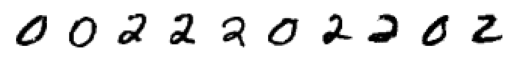

In [79]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a =  0 # TODO choose your digit
number_b =  2 # TODO choose your digit

digit_a_indexes = np.where(target==number_a)[0][:300] # select 300 indices for number a
digit_b_indexes = np.where(target==number_b)[0][:300] # select 300 indices for number b

# replace <> with correct arrays
targets = np.concatenate((target[digit_a_indexes], target[digit_b_indexes])) 
print(targets.shape[0]) # must be 600
images = np.concatenate((digit[digit_a_indexes], digit[digit_b_indexes]))
print(images.shape[0]) # must be 600

X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

# 1. Feature Extraction

You will create 2 feature extractors based on the numbers you choose. Feature extractors are mathematical operations that map an image (represented either as a 2D array or a 1D vector) into an alternative mathematical representation, such as a single scalar.  In this assignment, our feature extractors will be two functions which take in an image and output a single float. Please use mean or total intensity and one feature extractor metric, and then please create a second feature extractor metric that quantifies image symmetry. You may change the digits you wish to classify to make this classification problem easier.

In [80]:
#@title Hints

# 1. For symmetry take the difference between two halves of the image and take a mean of that.
# 2. You can have symmetry about vertical or horizontal axes

In [81]:
# please complete this function:
def compute_features(vector):
    image = vector.reshape(28, 28) # get back original image shape
    def compute_feature_a(image):
        '''compute_feature_a will compute the mean intensity of the image'''
        mean_intensity = np.mean(image)
        return mean_intensity

    def compute_feature_b(image):
        '''compute_feature_b will compute the symmetry score of the image'''
        symmetry_score = np.mean(np.abs(image[:, :14] - image[:, 14:]))
        return symmetry_score
    
    return compute_feature_a(image), compute_feature_b(image)

Once you compute these two features, you can apply them to your images. Don't worry about the details of the first function below, all it does is map the `compute_features` function you wrote to each image in your `X_train` variable.

Afterwards let us plot the features you've crafted to see if they can separate into two classes.

(0.09664865946378552, 0.4796318527410964)

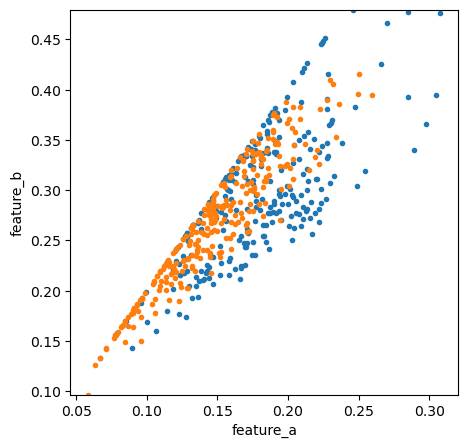

In [82]:
# Apply and plot your features (you can just run this block and inspect the output)

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')

plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

# 2. Linear Classification with Pseudo Inverse

`X_features` is a 2 dimensional array of features and `y_train` is our ground truth label. Find the best plane that separates these two classes using the pseudo inverse and plot it. For this problem, as discussed in class, we set the labels as `y=-1` for `number_a` and `y=1` for `number_b`.

The loss $L$ we would like to minimize for each $i$ row in our matrix is.

$$L  = \frac{1}{2}\Sigma (y^{(i)} - W^{T}x^{(i)})^{2}$$

where

$$x^{(i)} = 
\begin{bmatrix}
    feature_a \\
    feature_b \\
\end{bmatrix}$$

$$W = 
\begin{bmatrix}
    w_1 \\
    w_2 \\
\end{bmatrix}$$


In matrix form we convert $x^{(i)}$ into $X$ which is the number of examples we have, in our case is MNIST digit features extracted.

$$X = 
\begin{bmatrix}
    feature_{a1} & feature_{b1} \\
    feature_{a2} & feature_{b2} \\
    ... & ... \\
    feature_{ai} & feature_{bi} \\
\end{bmatrix}$$


$$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$


### Explain

Let's solve L analytically, by setting $\frac{d}{dW}L = 0$ and solving for $W$, showing your steps along the way. 

Step 1: $$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 2: $$ \frac{d}{dW}L  = \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 3: $$ \frac{d}{dW}L  =  \frac{2}{N}X^{T} (Y-XW)$$

Step 4: $$ \frac{2}{N}X^{T} (Y-XW)  =  0$$

### Compute
Going back to linear algebra, we can re-write the classification problem as $Xw = y^*$, as we did during class. Here, $X$ is our features matrix `X_features` that has the features of each data example along each row, $y^*$ is our `pseudo_y` vector, and $w$ is the unknown weights vector that we'd like to figure out.

The pseudo inverse is $$(X^{T}X)^{-1}X^{T} = X^{+}$$

Solving for $w$, $$w = X^{+}y^*$$

To perform this computation: 

#### (a) create a features vector $X$ and compute its pseudo inverse. (This is the var `X_features`)

#### (b) create a vector like $y^*$ to hold the labels. (Done below for you as `pseudo_y`)

#### (c) find $w$

In [83]:
# replace labels with +1 and -1
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

# Calculate w below
def calculate_w(X, pseudo_y):
    # Calculate the transpose of X
    X_transpose = np.transpose(X)
    # Calculate the product of X transpose and X
    X_product = np.dot(X_transpose, X)
    # Calculate the inverse of X product
    X_product_inv = np.linalg.inv(X_product)
    # Calculate the product of X product inverse and X transpose
    X_plus = np.dot(X_product_inv, X_transpose)

    weights = np.dot(X_plus, pseudo_y)
    return weights

weights = calculate_w(X_features, pseudo_y)

### (d) To examine the result of the least squares solution under this formulation, compute the train and test error using an appropriate threshold (i.e., 0). Does your trained model generalize well to the test data? 

Create a function called `accuracy_metrics` which does this. Remember that you might need to apply the feature extraction to your test data and create pseudo labels for it before you calculate test accuracy.

In [84]:
#@title Hints
# Inside the accuracy metrics function, calculate the predicted values using features and weights
# Set a label threshold, i.e. assign class 1 if the value is greater than some number and -1 otherwise
# compare the predicted labels to true labels and find the PERCENTAGE of correct predictions
# use the function for training data and testing data with correct arguments

In [85]:
def accuracy_metrics(features, weights, label):
    
    preds = np.dot(features, weights)
    preds[preds > 0] = 1
    preds[preds < 0] = -1
    correct = 0
    for i in range(len(preds)):
        if preds[i] == label[i]:
            correct += 1
    return correct/len(preds) * 100

# When you use the function,
# features should be your X_features
# label should be the true label

print(f"Training accuracy: {format(accuracy_metrics(X_features, weights, pseudo_y), '.2f')}%")

Training accuracy: 63.52%


### (e) Visualize the decision boundary corresponding to your chosen threshold using the provided `visualize_model` function.  

The function `visualize_model` takes in features, labels, and your calculated weights and shows a matplotlib figure. If we are using a bias term, this function assumes that the weight vector has format: `[weight0, weight1, bias]`. So bias is appended to the back of the weight vector.

In [86]:
# just run this block
import matplotlib.lines as mlines
def newline(weight):
    # adapted from https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
    if len(weight) == 2:
        p1 = weight[0]
        p2 = weight[1]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = 0
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax)
            ymin = -p1/p2*(xmin)
        l = mlines.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
       
    elif len(weight) == 3:
        p1 = weight[0]
        p2 = weight[1]
        b = weight[2]
        ax = plt.gca()
        xmin, xmax = ax.get_xbound()
        if(p2 == 0):
            xmin = xmax = -b/p1
            ymin, ymax = ax.get_ybound()
        else:
            ymax = -p1/p2*(xmax) - b/p2
            ymin = -p1/p2*(xmin) - b/p2
        l = mlines.Line2D([xmin,xmax], [ymin,ymax], color = "g", label = "Decision")
        ax.add_line(l)
       
    return l

def visualize_model(features, labels, weights):
    plt.figure(figsize=(5,5))
    X_features_a = features[np.where(labels==-1)]
    X_features_b = features[np.where(labels==1)]
    plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.', label = "{}".format(number_a))
    plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.', label = "{}".format(number_b))
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max())
    newline(weights)
    plt.gca().legend(loc = 1)
    return None

Plug in your weight variable and run the visualization.

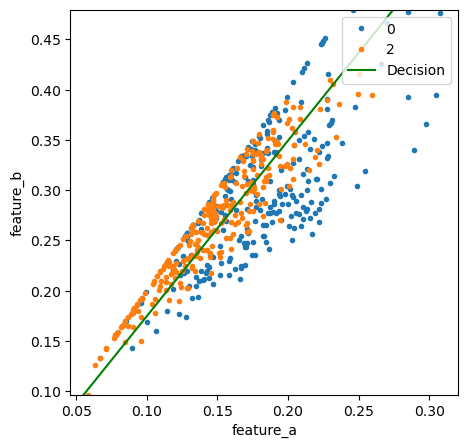

In [87]:
visualize_model(X_features, pseudo_y, weights)  # should output the datapoints with the decision boundary

### (f) Repeat the above steps after adding in a bias term, allowing for the classification line to not pass through the origin. You can do this by augmenting the X feature matrix with an additional feature column of ones, and making the unknown weight vector one entry longer -- does performance improve?

If you created your functions correctly, you shouldn't need to change them and you only need to modify `X_features`. Make sure to add this column of ones to the end of the array so that the visualization works properly and that the shape of `X_features` is now (length, 3) instead of (length, 2).

Training accuracy: 62.78%


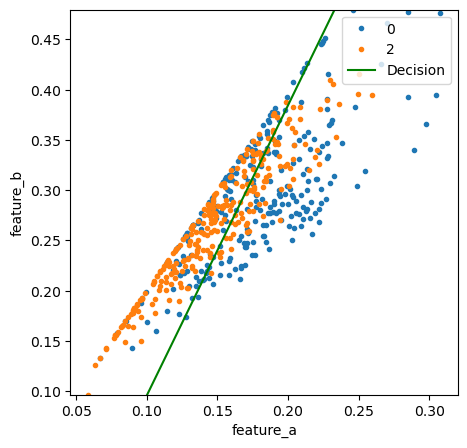

In [88]:
ones = np.ones((X_features.shape[0], 1))
X_features_updated = np.concatenate((X_features, ones), axis=1)

# Find w and bias

weights_updated = calculate_w(X_features_updated, pseudo_y)

# Get the test and train accuracy of your model with bias
print(f"Training accuracy: {format(accuracy_metrics(X_features_updated, weights_updated, pseudo_y), '.2f')}%")

# Visualize the model, you may need to change your code.
visualize_model(X_features_updated, pseudo_y, weights_updated)

# Part II

Once again, in Part II, we'll add a very small modification to your code in Part II. Here, let’s assume that this camera has a special filter in its lens that blurs the MNIST image in a special way before it is detected. Let’s model this 2D blur as a convolution with the 3x3 filter below.

$$X = 
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
\end{bmatrix}$$

Convolve the set of MNIST images with this kernel before proceeding to compute the two features of interest as in Part I: the total image intensity, and the image symmetry. Repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score. You can use the bias variable from the start for this.

**Note that this classification score (in some sense) reflects what would be possible with a “computational” camera, which has a special aperture shape for enhanced image classification.**

 - Plot Points after feature generation
 - Linear Classification - accuracy and plots

600
600


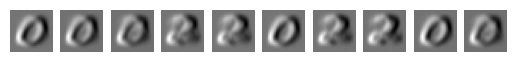

In [98]:
from scipy import signal

# Creating a blur filter
filter = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
filter_array = np.repeat([filter], 600, axis=0)

# Convolving the image with the blur filter
images_convolved = signal.convolve(images, filter_array, mode='same')
print(image_convolved.shape[0]) # must be 600

targets_convolved = np.concatenate((target[digit_a_indexes], target[digit_b_indexes])) 
print(targets.shape[0]) # must be 600

X_train, X_test, y_train, y_test = train_test_split(image_convolved, targets_convolved, test_size=0.1, random_state=42)

for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

(97.21265506202478, 186.4833433373349)

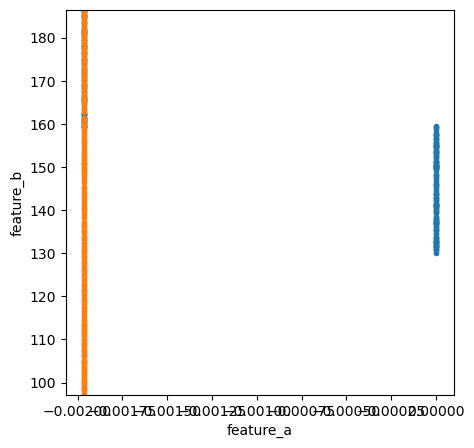

In [99]:
# Apply and plot your features (you can just run this block and inspect the output)

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.xlabel('feature_a')

plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 

Training accuracy: 82.41%


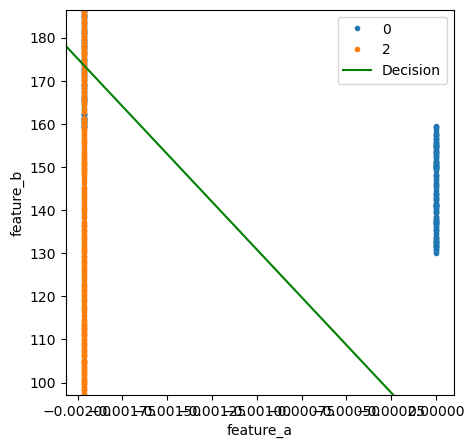

In [100]:
# replace labels with +1 and -1
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

# Adding bias
ones = np.ones((X_features.shape[0], 1))
X_features_updated = np.concatenate((X_features, ones), axis=1)

# Find w and bias
weights_updated = calculate_w(X_features_updated, pseudo_y)

# Get the test and train accuracy of your model with bias
print(f"Training accuracy: {format(accuracy_metrics(X_features_updated, weights_updated, pseudo_y), '.2f')}%")

# Visualize the model, you may need to change your code.
visualize_model(X_features_updated, pseudo_y, weights_updated)

# Part III

In Part III, we'll examine another way in which a computational imaging system can be built. let us assume that our camera system has filters in the Fourier Plane and we can record the intensity of images after the filtering.

Our feature generation will now change to reflect this imaging system. You will attempt:
 - Plot Points after feature generation
 - Linear Classification - accuracy and plots

First, write a function that generates the 2D Fourier transform of an image and plot the intensity and phase of the Fourier Transform for the input images.

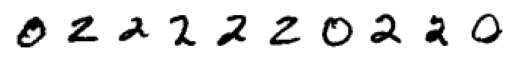

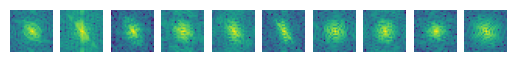

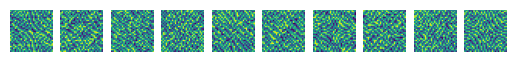

In [102]:
from numpy.fft import fft2

X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

def FourierT(image):
    image_fft = fft2(image)
    return image_fft

for index, image in enumerate(X_train[11:21]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

for index, image in enumerate(X_train[11:21]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')

    # Apply Fourier Transform
    image_fft = FourierT(image)

    # Shift the zero-frequency component to the center of the spectrum
    image_fft_shifted = np.fft.fftshift(image_fft)

    # Plot the magnitude spectrum
    plt.imshow(np.log(np.abs(image_fft_shifted)))
plt.show()

for index, image in enumerate(X_train[11:21]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    
    # Apply Fourier Transform
    image_fft = FourierT(image)

    # Shift the zero-frequency component to the center of the spectrum
    image_fft_shifted = np.fft.fftshift(image_fft)

    # Plot the phase spectrum
    image_fft_shifted_phase = np.angle(image_fft_shifted)
    plt.imshow(image_fft_shifted_phase)
plt.show()

Now, we can think of a hypothetical imaging system that can capture only the high frequency features or only the low frequency features. We can achieve this by applying a high pass filter and a low pass filter to the image. 

Write a function for each of them. The low pass filter should a be square of shape (10,10) and the high pass filter passes everything but this square. Return the filtered Fourier Transform magnitude for both.

In [103]:
#@title Hints
# Filtering is simply taking an elementwise product with a mask in the Fourier domain.
# For low pass filter, you can make a ones matrix of size (10,10) and pad with zeros to get the right shape
# For high pass, do the opposite.

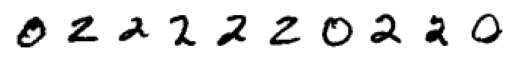

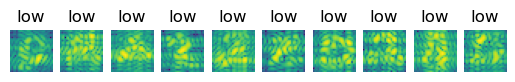

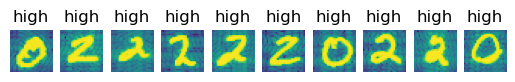

In [104]:
def high_pass(image):
    zeros = np.zeros((10, 10))
    
    # Create a padding of 9 on all sides to create a high pass filter
    high_pass_filter = np.pad(zeros, [(9, 9), (9, 9)], mode='constant', constant_values=(1))

    # Apply the high pass filter
    image_fft = FourierT(image)
    image_fft_filtered = image_fft * high_pass_filter
    image_fft_filtered = np.fft.ifftshift(image_fft_filtered)
    image_filtered = np.fft.ifft2(image_fft_filtered)

    return np.abs(image_filtered)

def low_pass(image):
    ones = np.ones((10, 10))
    
    # Create a padding of 9 on all sides to create a low pass filter
    low_pass_filter = np.pad(ones, [(9, 9), (9, 9)], mode='constant')

    # Apply the low pass filter
    image_fft = FourierT(image)
    image_fft_filtered = image_fft * low_pass_filter
    image_fft_filtered = np.fft.ifftshift(image_fft_filtered)
    image_filtered = np.fft.ifft2(image_fft_filtered)
    
    return np.abs(image_filtered)

for index, image in enumerate(X_train[11:21]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

for index, image in enumerate(X_train[11:21]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    im_fft = low_pass(image)
    plt.imshow(np.log(im_fft))
    plt.title("low")
plt.show()

for index, image in enumerate(X_train[11:21]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    im_fft = high_pass(image)
    plt.imshow(np.log(im_fft))
    plt.title("high")
plt.show()

Now use the mean value for the high frequency magnitudes and low frequency magnitudes as features and redo the linear classification. You can add the bias variable from the start for this.

In [105]:
def compute_features(vector):
    image = vector.reshape(28, 28) # get back original image shape
    def compute_hf_mean(image):
        '''computes the mean magnitude of high frequency features'''
        im_fft = high_pass(image)
        mean_intensity = np.mean(im_fft)
        return mean_intensity

    def compute_lf_mean(image):
        '''computes the mean magnitude of low frequency features'''
        im_fft = low_pass(image)
        mean_intensity = np.mean(im_fft)
        return mean_intensity
    
    return compute_hf_mean(image), compute_lf_mean(image)

(0.00599343982969606, 0.024958718312921648)

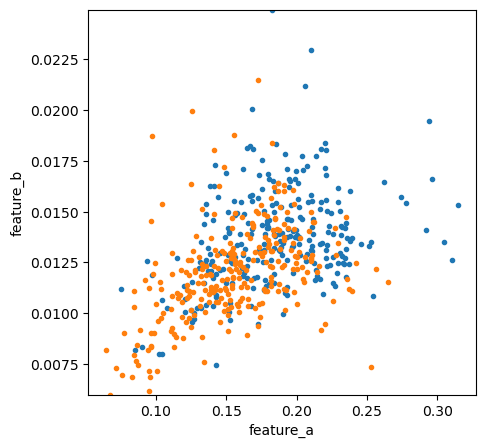

In [106]:
# Apply and plot your features (you can just run this block and inspect the output)

X_f_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_f_features_a = X_f_features[np.where(y_train==number_a)]
X_f_features_b = X_f_features[np.where(y_train==number_b)]

plt.figure(figsize=(5,5))
plt.plot(X_f_features_a[:, 0], X_f_features_a[:, 1], '.')
plt.plot(X_f_features_b[:, 0], X_f_features_b[:, 1], '.')
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_f_features[:, 1].min(), X_f_features[:, 1].max()) 